In [ ]:
#! pip install python-terrier

!pip install --upgrade python-terrier

!pip install --upgrade git+https://github.com/Georgetown-IR-Lab/OpenNIR
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_t5

  Cloning https://github.com/Georgetown-IR-Lab/OpenNIR to /tmp/pip-req-build-9t6xeia4
  Running command git clone -q https://github.com/Georgetown-IR-Lab/OpenNIR /tmp/pip-req-build-9t6xeia4
  Cloning https://github.com/terrierteam/pyterrier_t5 to /tmp/pip-req-build-wvqw3wca
  Running command git clone -q https://github.com/terrierteam/pyterrier_t5 /tmp/pip-req-build-wvqw3wca


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#libraries

import pyterrier as pt
import string 
from nltk.stem.porter import *
from nltk.tokenize import WordPunctTokenizer
import pandas as pd

Function for pre-processing steps of the queries. 

In [ ]:
covid19_synonyms_nospace = ['covid19',
                    'covid2019',
                    'coronavirusdisease19',
                    'coronavirusdisease2019',
                    'coviddisease2019',
                    'coviddisease19',
                    'sarscov2', 
                    '2019ncov',
                    'ncov2019',
                    'coronavirus2019',
                    'coronavirus2',
                    'wuhanpneumonia',
                    'wuhanvirus',
                    'wuhancoronavirus',
                    'novelcoronavirus',
                    'novelcovid'
                    ]
covid19_synonyms_space =[
                         'covid 19',
                         'covid 2019',
                         'coronavirus disease 19',
                         'ncov 2019',
                         'n cov2019',
                         'n cov 2019',
                         '2019n cov',
                         '2019 ncov',
                         '2019 n cov',
                         'coronavirus 2019',
                         'coronavirus 2',
                         'wuhan pneumonia',
                         'wuhan virus',
                         'wuhan coronavirus',
                         'novel coronavirus',
                         'novel covid',
                         'covid disease 2019',
                         'coronavirus disease 2019',
                         'covid disease 19',
                         'sars cov 2',
                         'sars cov2',
                         'sarscov 2'
]

In [ ]:
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation+'‐'+'′'+'–'+'‘'+'’'+'“'+'”'])
    return punctuationfree

import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
  tokenized_text = WordPunctTokenizer().tokenize(text)

  tokenized_text_without_stopwords = []
  for token in tokenized_text:
    if token.lower() not in stop_words:
      tokenized_text_without_stopwords.append(token)
  return " ".join(tokenized_text_without_stopwords)

def tokenization(text):
  tokenized_text = WordPunctTokenizer().tokenize(text)
  return tokenized_text

def covid_preprocess(text):
  for s in covid19_synonyms_space:
    text = text.replace(s, s.replace(" ", ""))
  return text

def remove_number_after_space(text):
  text = re.sub('\s(\d)+', ' ', text, regex=True)
  return text

def porter_stemmer(text):
  stemmer = PorterStemmer()
  return_text = stemmer.stem(text)

  return return_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#load datasets and init pyterrier

if not pt.started():
  pt.init()

root_dir = '/content/gdrive/MyDrive'
base_dir = root_dir + '/Progetto IR/data'
#base_dir = root_dir + '/IR_Dataset/'

collection = pd.read_pickle(base_dir + "/collection.pkl")
qrels = pd.read_pickle(base_dir + "/qrels.pkl")
queries = pd.read_pickle(base_dir + "/queries.pkl")


####Indexing

In this part there is the initialization of the index. We try different ingredients for the preprocessing (as it explain in the relation, but we leave the best approach).

In [ ]:
pt.set_property("termpipelines", "")
pt.set_property("termpipelines", "Stopwords")
#pt.set_property("termpipelines", "PorterStemmer")

pd_indexer = pt.DFIndexer("/pd_index", overwrite = True)
indexref = pd_indexer.index(collection["text"], collection["docno"], collection["date"], collection["title"])


17:46:48.366 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
17:49:20.100 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 54937 empty documents
17:49:20.218 [main] ERROR org.terrier.structures.indexing.Indexer - Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BasicIndexer.createDirectIndex(BasicIndexer.java:346)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:369)


In [ ]:
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 192509
Number of terms: 188603
Number of postings: 11824971
Number of fields: 0
Number of tokens: 16819835
Field names: []
Positions:   false



In [ ]:
display(queries.head())

queries['query_adhoc'] = [el.lower() for el in queries['query_adhoc']]
queries['query_adhoc'] = [remove_punctuation(el) for el in queries['query_adhoc']]
#queries['query_adhoc'] = [remove_stopwords(el) for el in queries['query_adhoc']]
#queries['query_adhoc'] = [porter_stemmer(el) for el in queries['query_adhoc']]

queries['query_desc'] = [el.lower() for el in queries['query_desc']]
queries['query_desc'] = [remove_punctuation(el) for el in queries['query_desc']]
#queries['query_desc'] = [remove_stopwords(el) for el in queries['query_desc']]
#queries['query_desc'] = [porter_stemmer(el) for el in queries['query_desc']]

queries['query_nar'] = [el.lower() for el in queries['query_nar']]
queries['query_nar'] = [remove_punctuation(el) for el in queries['query_nar']]
#queries['query_nar'] = [remove_stopwords(el) for el in queries['query_nar']]
#queries['query_nar'] = [porter_stemmer(el) for el in queries['query_nar']]

queries.head()


,index,qid,query,query_adhoc,query_desc,query_nar
0,0,1,NaN,coronavirus origin,what is the origin of COVID-19,seeking range of information about the SARS-Co...
1,1,2,NaN,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the SARS-Co...
2,2,3,NaN,coronavirus immunity,will SARS-CoV2 infected people develop immunit...,seeking studies of immunity developed due to i...
3,3,4,NaN,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Co...
4,4,5,NaN,animal models of COVID-19,what drugs have been active against SARS-CoV o...,Papers that describe the results of testing d...


,index,qid,query,query_adhoc,query_desc,query_nar
0,0,1,NaN,coronavirus origin,what is the origin of covid19,seeking range of information about the sarscov...
1,1,2,NaN,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the sarscov...
2,2,3,NaN,coronavirus immunity,will sarscov2 infected people develop immunity...,seeking studies of immunity developed due to i...
3,3,4,NaN,how do people die from the coronavirus,what causes death from covid19,studies looking at mechanisms of death from co...
4,4,5,NaN,animal models of covid19,what drugs have been active against sarscov or...,papers that describe the results of testing d...


In [ ]:
queries_adhoc = queries[['qid', 'query_adhoc']]
queries_adhoc.rename(columns = {"query_adhoc" : "query"}, inplace=True)

queries_desc = queries[['qid', 'query_desc']]
queries_desc.rename(columns = {"query_desc" : "query"}, inplace=True)

queries_narrative = queries[['qid', 'query_nar']]
queries_narrative.rename(columns = {"query_nar" : "query"}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
from pyterrier.measures import *

tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
dir = pt.BatchRetrieve(index, wmodel="DirichletLM")
dph = pt.BatchRetrieve(index, wmodel="DPH")

results = pt.Experiment(
    [tfidf, bm25, dir, dph],
    queries_adhoc,
    qrels,
    names = ["tf-idf", "bm25", "DirichletLM", "DPH"],
    eval_metrics=[AP@1000,P@5,P@10, 'map', 'ndcg', R@5, R@10, RR])
display(results)


results = pt.Experiment(
    [tfidf, bm25, dir, dph],
    queries_desc,
    qrels,
    names = ["tf-idf", "bm25", "DirichletLM", "DPH"],
    eval_metrics=[AP@1000,P@5,P@10, 'map', 'ndcg', R@5, R@10, RR])
display(results)

results = pt.Experiment(
    [tfidf, bm25, dir, dph],
    queries_narrative,
    qrels,
    names = ["tf-idf", "bm25", "DirichletLM", "DPH"],
    eval_metrics=[AP@1000,P@5,P@10, 'map', 'ndcg', R@5, R@10, RR])
display(results)

,name,AP@1000,P@5,P@10,map,ndcg,R@5,R@10,RR
0,tf-idf,0.136614,0.568,0.548,0.136614,0.319709,0.006963,0.012625,0.698584
1,bm25,0.136755,0.564,0.536,0.136755,0.319814,0.006939,0.012217,0.690903
2,DirichletLM,0.129191,0.436,0.464,0.129191,0.307969,0.005242,0.011065,0.633956
3,DPH,0.138300,0.592,0.574,0.138300,0.323266,0.006850,0.013748,0.717690


,name,AP@1000,P@5,P@10,map,ndcg,R@5,R@10,RR
0,tf-idf,0.095966,0.424,0.436,0.095966,0.279056,0.004600,0.009542,0.539165
1,bm25,0.096408,0.424,0.432,0.096408,0.280493,0.004584,0.009525,0.524033
2,DirichletLM,0.080185,0.344,0.354,0.080185,0.249789,0.004028,0.008485,0.465882
3,DPH,0.094373,0.484,0.450,0.094373,0.275915,0.005324,0.009736,0.573350


,name,AP@1000,P@5,P@10,map,ndcg,R@5,R@10,RR
0,tf-idf,0.078664,0.440,0.426,0.078664,0.229475,0.004798,0.009124,0.549489
1,bm25,0.080076,0.416,0.420,0.080076,0.233186,0.004634,0.009112,0.565842
2,DirichletLM,0.053071,0.288,0.292,0.053071,0.190887,0.002920,0.005898,0.452085
3,DPH,0.075782,0.432,0.422,0.075782,0.224069,0.004672,0.009387,0.549899


#Same query - Same results

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv(base_dir + "/embedding_desc.csv", header = None)

Clustering approach

[1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0
 0 1 0 0 0 0 1 0 1 1 0 0 1]
[1 1 2 2 2 1 2 2 1 2 1 2 1 1 0 0 1 1 1 2 1 2 2 2 2 2 1 1 2 1 1 1 2 1 1 2 2
 2 1 2 2 2 2 1 2 1 2 2 2 1]
[3 3 0 0 0 3 0 0 3 0 3 0 0 3 1 1 3 0 3 0 3 0 0 0 0 0 3 3 0 3 3 3 0 3 2 0 0
 0 3 0 0 0 0 2 0 3 0 0 0 2]
[2 2 0 4 4 2 4 4 2 4 2 0 2 4 3 3 2 2 2 4 2 4 4 4 0 4 2 1 0 2 2 2 4 2 2 4 4
 4 2 0 4 4 4 2 4 1 4 4 4 1]
[1 1 4 0 0 1 0 0 1 0 1 4 0 5 2 2 1 1 1 0 1 0 1 0 0 0 1 5 4 1 1 1 0 1 1 0 0
 0 1 4 0 0 1 1 0 5 1 0 0 3]
[1 1 2 0 3 1 0 3 1 3 1 2 0 5 6 6 1 0 1 3 1 0 3 3 3 0 1 5 2 0 1 1 3 1 1 0 0
 0 1 2 3 3 4 1 3 5 0 0 3 5]
[0 0 1 1 1 7 1 1 0 1 0 1 0 6 5 2 0 0 7 1 0 1 1 1 1 1 0 6 3 0 0 0 1 0 0 1 1
 1 0 1 1 1 1 0 1 6 0 1 1 4]
[3 3 1 4 4 3 4 4 3 4 3 1 3 6 5 7 3 3 3 4 3 4 0 0 4 4 3 6 4 3 3 3 4 3 3 4 4
 4 3 1 4 4 4 8 4 6 4 4 4 2]
[1 8 7 1 1 0 8 9 1 1 0 9 8 1 6 4 0 1 0 9 1 1 1 9 9 1 1 5 2 1 8 1 1 1 1 1 1
 1 1 9 9 1 1 1 9 5 1 1 9 3]


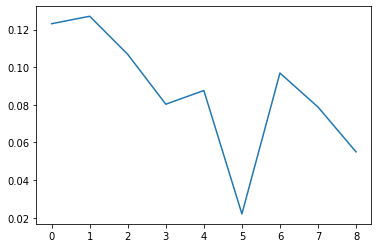

In [ ]:
kmax = 10
sil = []
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df)
  labels = kmeans.labels_
  print(labels)
  sil.append(silhouette_score(df, labels, metric = 'euclidean'))

import matplotlib.pyplot as plt

plt.plot(sil)

In [ ]:
from pyterrier.measures import *

tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
dir = pt.BatchRetrieve(index, wmodel="DirichletLM")
dph = pt.BatchRetrieve(index, wmodel="DPH") 

results = pt.Experiment(
    [tfidf, bm25, dir, dph],
    queries_desc,
    qrels,
    names = ["tf-idf", "bm25", "DirichletLM", "DPH"],
    eval_metrics=[P@5,P@10, 'ndcg', RR],
    perquery = True)
display(results)

query_id = []

for i in range(len(queries_desc)):
  l = [queries["qid"][i], labels[i]]
  query_id.append(l)

query_id_df = pd.DataFrame(query_id, columns = ["qid", "labels"])

results_bis = results.merge(query_id_df, on = "qid")

,name,qid,measure,value
600,DPH,1,RR,1.000000
601,DPH,1,P@5,0.600000
602,DPH,1,P@10,0.300000
603,DPH,1,ndcg,0.150692
636,DPH,10,RR,1.000000
...,...,...,...,...
31,tf-idf,8,ndcg,0.200318
32,tf-idf,9,RR,0.066667
33,tf-idf,9,P@5,0.000000
34,tf-idf,9,P@10,0.000000
